# Numpyro SVI

In [1]:
# generic & ml
import config as cfg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
from collections import namedtuple
from sklearn.decomposition import PCA
import scanpy as sc

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS
from numpyro.infer import SVI, Trace_ELBO
from numpyro.handlers import seed, trace
import pprint as pp

from noise_model import Noise_Model
from utils import *
from jax_models import *

/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
default_device = jax.devices()[0]

I0000 00:00:1703169662.036323       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


# Loading data

In [3]:
data_0, data, n_c, dm, sample_id, sample_names = get_data_from_anndata(
    cfg.path, cfg.genes
)
# some useful variables
NC, NG = data.shape
NS = dm.shape[1]

/Users/salati/Documents/CODE/github/LiverZonation/utils.py:59: ImplicitModificationWarning: Setting element `.layers['n_cg']` of view, initializing view as actual.
  data.layers["n_cg"] = data.X.toarray()


### PCA to initalize the lobular coordinate $x$

In [4]:
pca = PCA(n_components=2, whiten=False)
X_pca = data.layers["f_cg"]

# normalize yourself
X_pca = X_pca - X_pca.mean(axis=0)[None, :]
X_pca = X_pca / np.sqrt(X_pca.var(axis=0))[None, :]
PC = pca.fit_transform(X_pca)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'PC2 entries values')

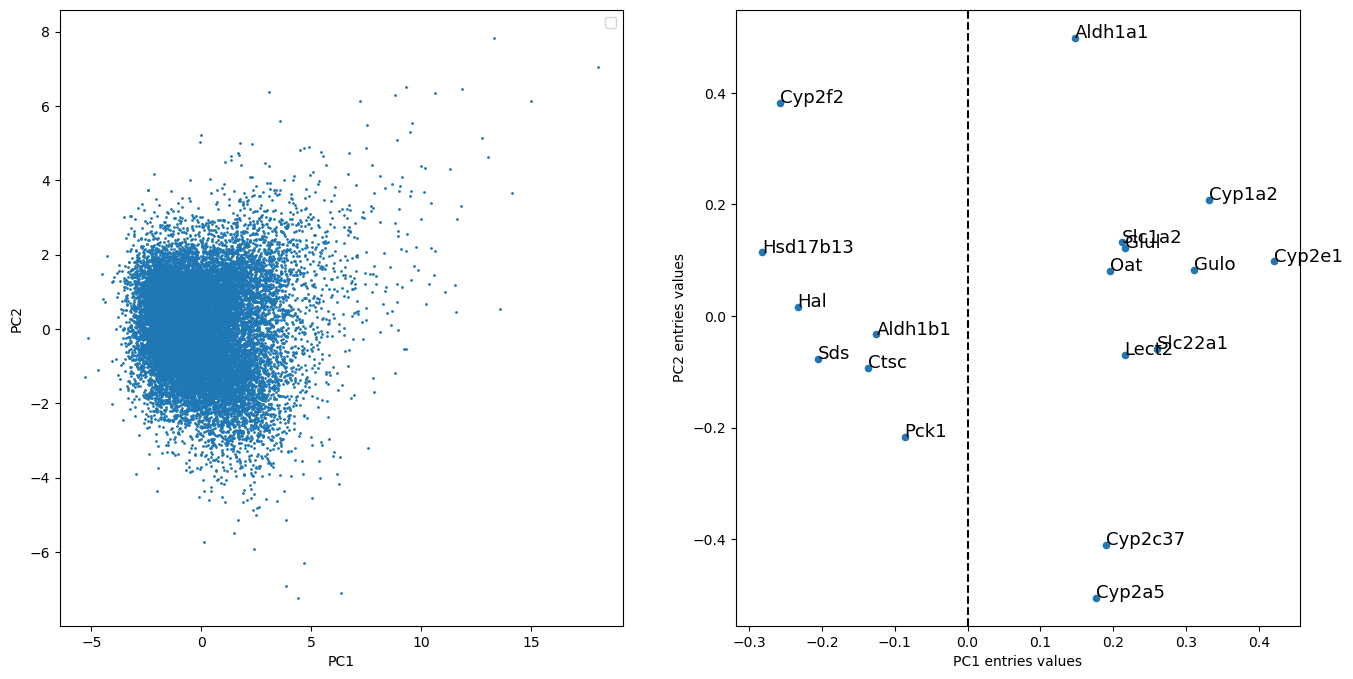

In [5]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.scatter(PC[:, 0], PC[:, 1],  s=1)

plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
# plt.scatter(PC[:,0], PC[:,1], s=1,  c=mask_f, cmap='plasma')
# first two eigenvectors
x = pca.components_[0, :]
y = pca.components_[1, :]

plt.subplot(122)
plt.scatter(x, y, 20)
ix = np.abs(x) > np.percentile(np.abs(x), 0)
iy = np.abs(y) > np.percentile(np.abs(y), 0)
ii = np.logical_or(ix, iy)
# print(np.sum(ii))
for i, txt in enumerate(data.var.index[ii]):
    plt.annotate(txt, (x[ii][i], y[ii][i]), fontsize=13)

#plot a vertical line for x = 0
plt.axvline(x=0, color='k', linestyle='--')

plt.xlabel("PC1 entries values")
plt.ylabel("PC2 entries values")


We can observe that PC1 perfectly separates protal to central genes, we therefore leverage the projection of data on such first principal component to initialize the bayesian model latent variables

In [6]:
# component that captures zonation, it needs to be checked
pc = 0
x_unif = PC[:, pc]
x_unif = x_unif - x_unif.mean()
x_unif = x_unif / np.sqrt(x_unif.var())

Here we also fit the the gene coefficients $a_g$ and $b_g$ with a Generalized Linear Model with Negative Bionomial noise: 
$$\forall c \forall g \\
\mu_{c,g} = exp(a_g * x_c + b_g)
$$
where $\mu_{c,g}$ is the mean of the negative binomial distrbution that generates the data entry $E_{c,g}$  
In this step the positions are kept fixed and the coefficients $a$ and $b$ are found for every gene

In [7]:
coef_pau = fit_coeff(data, x_unif, cfg.genes)

# SVI

In [8]:
a0_pau = coef_pau[:, 0]
a1_pau = coef_pau[:, 1]

In [9]:
DATA = data[:, :].layers["n_cg"]

NC = DATA.shape[0]
NG = DATA.shape[1]


# INTIALISE BOTH!
X = x_unif.reshape(NC, 1)
A1 = a1_pau.reshape(1, NG)
A0 = a0_pau.reshape(NG)

DISP = 0.3


# resizing the data

# mask for first 2 samples ....
num_samples = 11
keep = sample_id < num_samples
n_data = keep.sum()
DATA = DATA[0:n_data, :]

NC2 = DATA.shape[0]

X = X[0:n_data]
log_c = np.log(np.array(data.obs["n_c"])[0:n_data]).reshape(n_data, 1)

design_matrix = make_design_matrix_numpy(sample_id)
design_matrix = design_matrix[0:n_data, 0:num_samples]

NS2 = design_matrix.shape[1]

In [10]:
DATA.shape
design_matrix.shape

(20080, 11)

In [11]:
# A0 = a0_pau.reshape(1, NG)
A0 = [A0 for i in range(NS2)]
A0 = np.stack(A0)
A0.shape

(11, 18)

In [12]:
mp = dict(
    a0_loc=A0,
    a1_loc=A1,
    x=X,
    log_n_UMI=log_c,
    disp=0.3,
    dm=design_matrix,
)
MyTuple = namedtuple("param", mp)
MP = MyTuple(**mp)

In [13]:
rng_key = random.PRNGKey(0)
# exec_trace = trace(seed(model, rng_key)).get_trace(MP, DATA)
# pp.pprint(exec_trace)

exec_trace = trace(seed(guide, rng_key)).get_trace(MP, DATA)
# pp.pprint(exec_trace)

In [14]:
# numpyro.render_model(model, model_args=(MP, DATA), render_distributions=False)

In [15]:


# run SVI

optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, MP, DATA)

100%|██████████| 1000/1000 [00:16<00:00, 59.82it/s, init loss: 909740.0625, avg. loss [951-1000]: 435719.0000]


Text(0.5, 0, 'step')

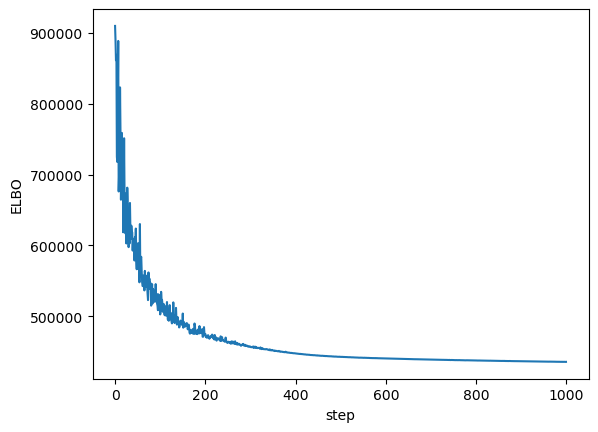

In [16]:
# show ELBO_loss
plt.plot(svi_result.losses)
plt.ylabel("ELBO")
plt.xlabel("step")


# Analysis of SVI parameters

In [17]:
params = svi_result.params

a0_pyro = params["a0_loc"].squeeze()
a1_pyro = params["a1_loc"].squeeze()
x_pyro = params["x_loc"].squeeze()

a0_std = params["a0_scale"].squeeze()
a1_std = params["a1_scale"].squeeze()
x_std = params["x_scale"].squeeze()

print(a0_pyro.shape, a1_pyro.shape, x_pyro.shape)

(11, 18) (18,) (20080,)


Text(0, 0.5, 'x MCMC')

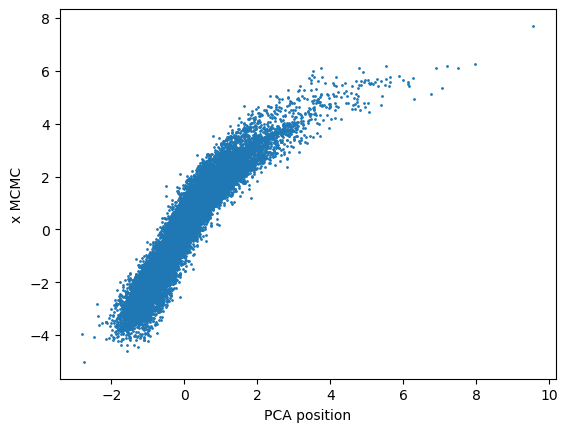

In [18]:
plt.scatter(x_unif[0:n_data], x_pyro, s=1)
# axis labels
plt.xlabel("PCA position")
plt.ylabel("x MCMC")

In [20]:
genes = cfg.genes

Text(0, 0.5, 'a0 std across the 11 samples')

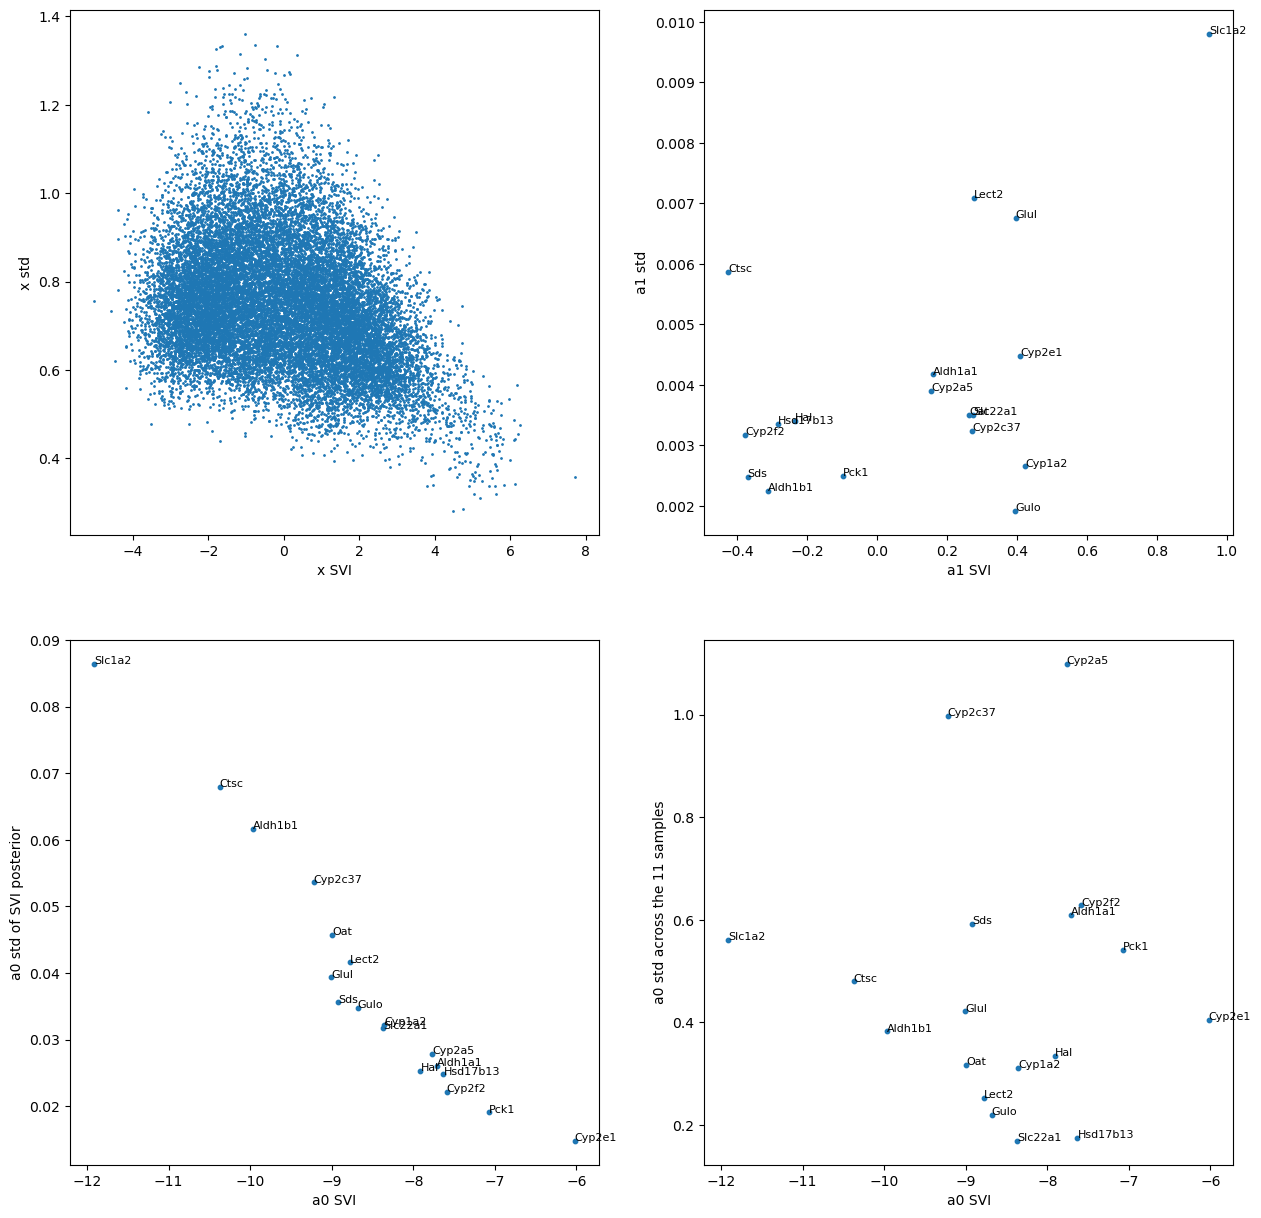

In [21]:
plt.figure(figsize=(15, 15))

# plot x_pyro against its std
plt.subplot(221)
plt.scatter(x_pyro, x_std, s=1)
plt.xlabel("x SVI")
plt.ylabel("x std")

# plot a1_pyro against its std, add gene names
plt.subplot(222)
plt.scatter(a1_pyro, a1_std, s=10)
for i, txt in enumerate(genes):
    plt.annotate(txt, (a1_pyro[i], a1_std[i]), fontsize=8)
plt.xlabel("a1 SVI")
plt.ylabel("a1 std")

# plot a0_pyro against its std, add gene names, avaraging a0 over dim 0
plt.subplot(223)
plt.scatter(a0_pyro.mean(0), a0_std.mean(0), s=10)
for i, txt in enumerate(genes):
    plt.annotate(txt, (a0_pyro.mean(0)[i], a0_std.mean(0)[i]), fontsize=8)
plt.xlabel("a0 SVI")
plt.ylabel("a0 std of SVI posterior")

# plot a0_pyro against its std, add gene names, avaraging a0 over dim 1
plt.subplot(224)
plt.scatter(a0_pyro.mean(0), a0_pyro.std(0), s=10)
for i, txt in enumerate(genes):
    plt.annotate(txt, (a0_pyro.mean(0)[i], a0_pyro.std(0)[i]), fontsize=8)

plt.xlabel("a0 SVI")    
plt.ylabel("a0 std across the 11 samples")